### ■ **Libraries**

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T

import os
import pandas as pd
import numpy as np
import random

## to plot figures & images
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

## to show the progress of the training
from tqdm import tqdm
import pathlib
import time
import datetime
from IPython import display

from models.motion_normalizer import MotionNormalizer
from models.motion_warper import MotionWarper

from utils.flow_utils import calc_flow, flow_to_polar, polar_to_image
from dataset.dataset import array2tensor, tensor2array

### ■ **Device**

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### ■ **Load Pre-Trained Models**

In [3]:
motion_normalizer = MotionNormalizer(in_channels=2, 
                                     out_channels=2, 
                                     dim=64, 
                                     encoder_res=2, 
                                     decoder_res=5, 
                                     n_sampling=4)

motion_warper  = MotionWarper(motion_channels=2, 
                              rgb_channels=3,
                              dim=64, 
                              encoder_res=4, 
                              decoder_res=4, 
                              n_sampling=2)

In [4]:
def load_eval_checkpoint(motion_normalizer, motion_warper, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    if os.path.isfile(filename):
        print("> loading checkpoint '{}'".format(filename), end='')
        checkpoint = torch.load(filename, map_location=device)
        start_epoch = checkpoint['epoch']
        motion_normalizer.load_state_dict(checkpoint['flow_gen_state_dict'])
        motion_warper.load_state_dict(checkpoint['img_gen_state_dict'])
        print(' .... done')

    return  motion_normalizer, motion_warper

## load pre-trained models
filename = './weights/best_model.pth'
motion_normalizer, motion_warper = load_eval_checkpoint(motion_normalizer, 
                                                        motion_warper,
                                                        filename)

## to device
motion_normalizer = torch.nn.DataParallel(motion_normalizer).to(device)
motion_warper = torch.nn.DataParallel(motion_warper).to(device)

## eval mode
motion_normalizer.eval()
motion_warper.eval()

print('')

In [5]:
## parameters
shape = (128, 128)
flow_algo = 'Farneback'
max_mag = 10.0
min_mag = None

### ■ **Demos**
#### **I. Frontal View Synthesis (FVS) & Facial Expression Preserving**

In [6]:
def demo_FVS(inp_img_path, tar_img_path, ntr_img_path, save_fname=None):
    """to plot frontalized faces"""

    inp_img = cv2.imread(inp_img_path, 0)
    tar_img = cv2.imread(tar_img_path, 0)
    ntr_img = cv2.imread(ntr_img_path, 0)

    inp_img = cv2.resize(inp_img, tar_img.shape, interpolation=cv2.INTER_LINEAR)
    
    ## calculate polar optical flow
    inp_flow = calc_flow(inp_img, tar_img, flow_algo)
    inp_flow = flow_to_polar(inp_flow, max_mag=max_mag, min_mag=min_mag, normalize=True, shape=shape)
    
    ## resize
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_GRAY2RGB) / 255
    tar_img = cv2.cvtColor(tar_img, cv2.COLOR_GRAY2RGB) / 255
    inp_img = cv2.resize(inp_img, shape, interpolation=cv2.INTER_LINEAR)
    tar_img = cv2.resize(tar_img, shape, interpolation=cv2.INTER_LINEAR)
    
    ## scale to [-1, 1]
    inp_img  = (-2.0 * inp_img + 1.0)
    tar_img  = (-2.0 * tar_img + 1.0)
    inp_flow = (-2.0 * inp_flow + 1.0)
    
    ## to tensors (c, w, h)
    inp_img  = array2tensor()(inp_img)
    inp_flow = array2tensor()(inp_flow)
    
    ## reshape (1, c, w, h)
    inp_flow = torch.unsqueeze(inp_flow, dim=0)
    inp_img  = torch.unsqueeze(inp_img, dim=0)
    
    gen_flow = motion_normalizer(inp_flow)
    gen_img  = motion_warper(inp_img, gen_flow)
    
    ## back to (w, h, c)
    inp_flow = tensor2array(inp_flow[0])
    gen_flow = tensor2array(gen_flow[0])
    gen_img  = tensor2array(gen_img[0])
    inp_img  = tensor2array(inp_img[0])
    
    ## display        
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    axes[0].imshow(-.5*inp_img+.5, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(-.5*tar_img+.5, cmap='gray')
    axes[1].set_title('Expression + Pose')
    axes[1].axis('off')
    axes[2].imshow(polar_to_image(-.5*inp_flow+.5, max_mag=max_mag, normalized=True))
    axes[2].set_title('Input Flow')
    axes[2].axis('off')
    axes[3].imshow(polar_to_image(-.5*gen_flow+.5, max_mag=max_mag, normalized=True))
    axes[3].set_title('Frontalized Flow (Ours)')
    axes[3].axis('off')                   
    axes[4].imshow(-.5*gen_img +.5, cmap='gray')
    axes[4].set_title('Warped Image (Ours)')
    axes[4].axis('off')
    
    if save_fname:
        fig.tight_layout()
        fig.savefig(save_fname, bbox_inches='tight')
        
    plt.show()

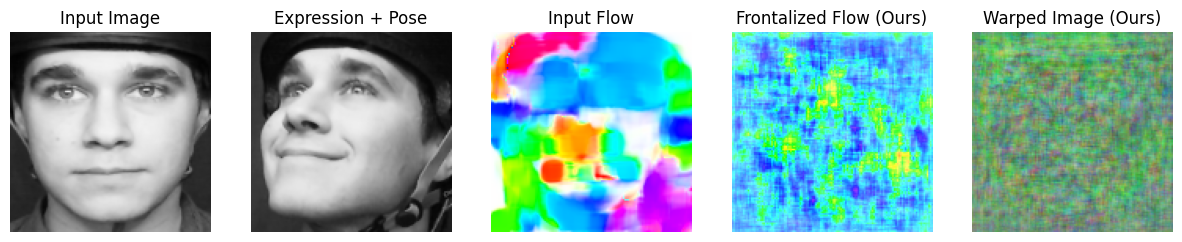

In [7]:
## paths to images
inp_img_path     = './images/img_013.png'
tar_img_path     = './images/img_036.png'
neutral_img_path = './images/img_013.png'

## demo
demo_FVS(inp_img_path, tar_img_path, neutral_img_path)

#### **II. Cross-subject Facial Motion Transfer (FMT)**

In [8]:
def demo_FMT(inp_img_path, tar_img_path, ntr_img_path, save_fname=None):
    """to plot frontalized faces"""

    inp_img = cv2.imread(inp_img_path, 0)
    tar_img = cv2.imread(tar_img_path, 0)
    ntr_img = cv2.imread(ntr_img_path, 0)
    
    ## calculate polar optical flow
    inp_flow = calc_flow(inp_img, tar_img, flow_algo)
    
    inp_flow = flow_to_polar(inp_flow, max_mag=max_mag, min_mag=min_mag, normalize=True, shape=shape)
    
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_GRAY2RGB) / 255
    tar_img = cv2.cvtColor(tar_img, cv2.COLOR_GRAY2RGB) / 255
    ntr_img = cv2.cvtColor(ntr_img, cv2.COLOR_GRAY2RGB) / 255
    
    inp_img = cv2.resize(inp_img, shape, interpolation=cv2.INTER_LINEAR)
    tar_img = cv2.resize(tar_img, shape, interpolation=cv2.INTER_LINEAR)
    ntr_img = cv2.resize(ntr_img, shape, interpolation=cv2.INTER_LINEAR)
    
    ## scale to [-1, 1]
    inp_img  = (-2.0 * inp_img + 1.0)
    tar_img  = (-2.0 * tar_img + 1.0)
    ntr_img  = (-2.0 * ntr_img + 1.0)
    inp_flow = (-2.0 * inp_flow + 1.0)
    
    ## to tensors (c, w, h)
    ntr_img  = array2tensor()(ntr_img)
    inp_flow = array2tensor()(inp_flow)
    
    ## reshape (1, c, w, h)
    inp_flow = torch.unsqueeze(inp_flow, dim=0)
    ntr_img  = torch.unsqueeze(ntr_img, dim=0)
    gen_img  = motion_warper(ntr_img, inp_flow)
    
    ## back to (w, h, c)
    inp_flow = tensor2array(inp_flow[0])
    gen_img  = tensor2array(gen_img[0])
    ntr_img  = tensor2array(ntr_img[0])
    
    ## display        
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    axes[0].imshow(-.5*inp_img+.5, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(-.5*tar_img+.5, cmap='gray')
    axes[1].set_title('Target Image')
    axes[1].axis('off')
    axes[2].imshow(polar_to_image(-.5*inp_flow+.5, max_mag=max_mag, normalized=True))
    axes[2].set_title('Motion to Warp')
    axes[2].axis('off')              
    axes[3].imshow(-.5*ntr_img+.5, cmap='gray')
    axes[3].set_title('Neutral Face')
    axes[3].axis('off')
    axes[4].imshow(-.5*gen_img+.5, cmap='gray')
    axes[4].set_title('Warped Face (Ours)')
    axes[4].axis('off')
    
    if save_fname:
        fig.tight_layout()
        fig.savefig(save_fname, bbox_inches='tight')
        
    plt.show()

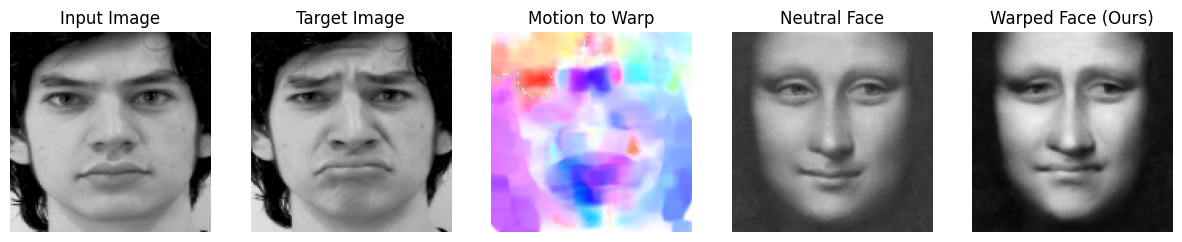

In [9]:
## paths to images
inp_img_path     = './images/img_002.png'
tar_img_path     = './images/img_063.png'
neutral_img_path = './images/mona.jpg'

demo_FMT(inp_img_path, tar_img_path, neutral_img_path)